### Baixando as bibliotecas necessárias, lendo o arquivo e exibindo as primeiras linhas verificando estatisticas descritivas
junto com histrogramas.

In [149]:
# importando bibliotecas necessacias 
import os 
import tarfile
import urllib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from zlib import crc32
from sklearn.model_selection import StratifiedShuffleSplit
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

In [150]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [151]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

fetch_housing_data()


In [152]:
fetch_housing_data()
housing = pd.read_csv("datasets/housing/housing.csv")
housing.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [153]:
# Conta a frequência de cada categoria
housing["ocean_proximity"].value_counts()  

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [154]:
# Exibe informações sobre o DataFrame
housing.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [155]:
# Exibe estatísticas descritivas do DataFrame
housing.describe() 

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


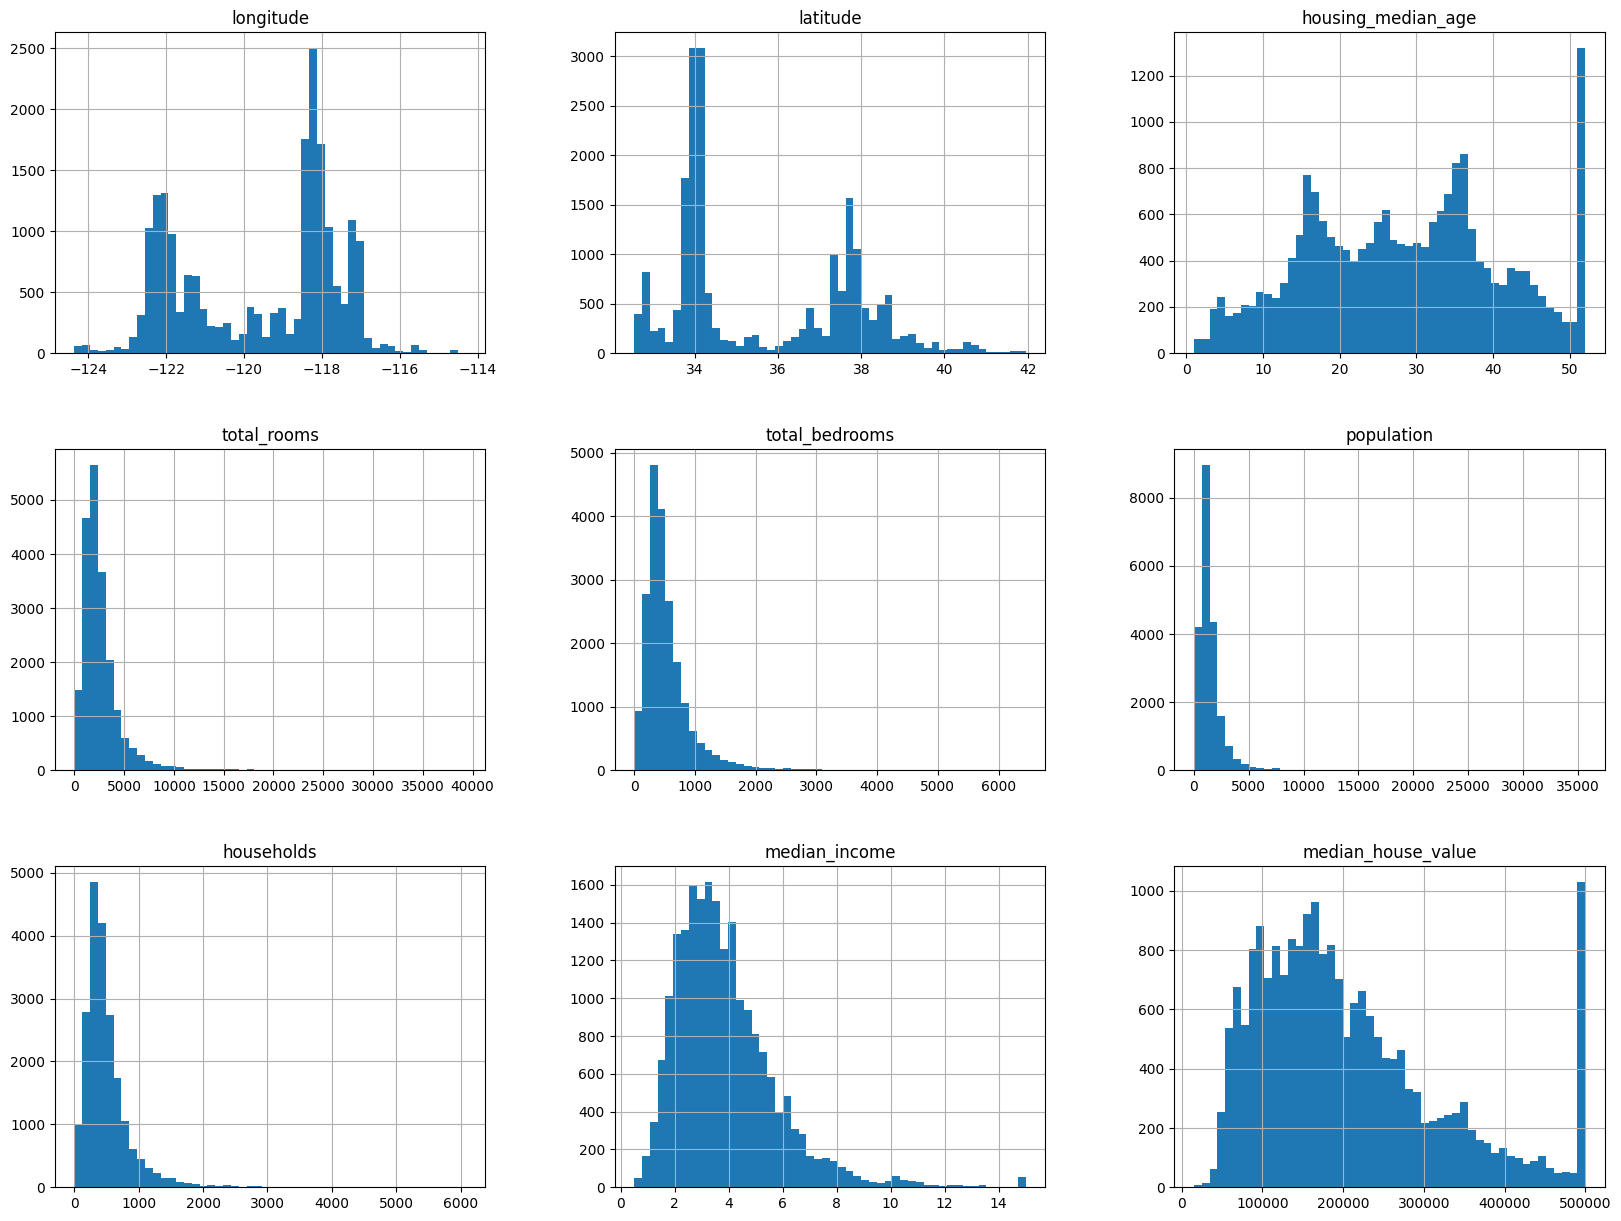

In [156]:
# Exibe o histograma das variáveis numéricas
housing.hist(bins=50, figsize=(20, 15))
plt.show()

### Separando os dados em treino e teste

In [157]:
def split_train_test(data, test_ratio): # data — um DataFrame (por ex: do pandas) com todos os dados que serão divididos.test_ratio — fração dos dados que serão usados para teste (ex: 0.2 para 20%).
    shuffled_indices = np.random.permutation(len(data)) #Cria uma lista com os índices dos dados, embaralhados aleatoriamente.
    test_set_size = int(len(data) * test_ratio) #Seleciona os primeiros test_set_size índices embaralhados para compor o conjunto de teste.
    test_indices = shuffled_indices[:test_set_size] #Usa .iloc[] para acessar as linhas correspondentes aos índices sorteados para cada conjunto.
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [158]:
train_test, test_set = split_train_test(housing, 0.2)
len(train_test) #quantas linhas (registros) estão no conjunto de treino

16512

In [159]:
len(test_set) #quantas linhas (registros) estão no conjunto de treino

4128

In [160]:
def test_set_check(identifier, test_ratio, hash): #Retorna True se o identificador deve entrar no conjunto de teste.
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32  # compara com o limiar: test_ratio * 2^32
def split_train_test_by_id(data, test_ratio, id_column, hash=crc32):#Recebe um DataFrame, a proporção de teste e o nome da coluna de ID.
    ids = data[id_column] # cria uma máscara booleana: True → em teste; False → em treino
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [161]:
housing_with_id = housing.reset_index()  # Cria uma nova coluna "index" com os índices originais
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

### Criando uma nova coluna "income_cat" com categorias de renda para evitar viés de amostragem.

In [162]:
housing["income_cat"] = pd.cut(housing["median_income"],
                                bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                labels=[1, 2, 3, 4, 5]) # Cria uma nova coluna "income_cat" com categorias de renda

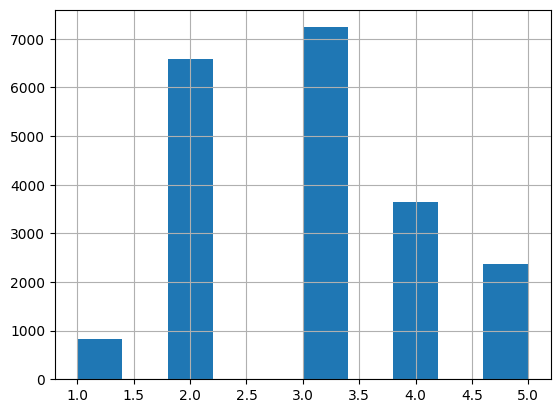

In [163]:
housing["income_cat"].hist()  # Exibe o histograma da coluna "income_cat com as categorias de renda
plt.show()

### Amostragem Estratificada

In [164]:
split= StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # Cria um objeto StratifiedShuffleSplit para amostragem estratificada
for train_index, test_index in split.split(housing, housing["income_cat"]):  # Gera os índices de treino e teste
    strat_train_set = housing.loc[train_index]  # Cria o conjunto de treino estratificado
    strat_test_set = housing.loc[test_index]  # Cria o conjunto de teste estratificado

In [165]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)  # Verifica a proporção das categorias de renda no conjunto de teste estratificado

income_cat
3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: count, dtype: float64

### Removendo a coluna "income_cat" do conjunto de treino e teste para os dados ficarem como originalmente.

In [166]:
for set_ in (strat_train_set, strat_test_set):  # Remove a coluna "income_cat" dos conjuntos de treino e teste
    set_.drop("income_cat", axis=1, inplace=True)  # axis=1 indica que estamos removendo uma coluna

### Explorando os dados para obter informaçoes uteis para o modelo

In [167]:
housing = strat_train_set.copy()  # Cria uma cópia do conjunto de treino estratificado para manipulação

<Axes: xlabel='longitude', ylabel='latitude'>

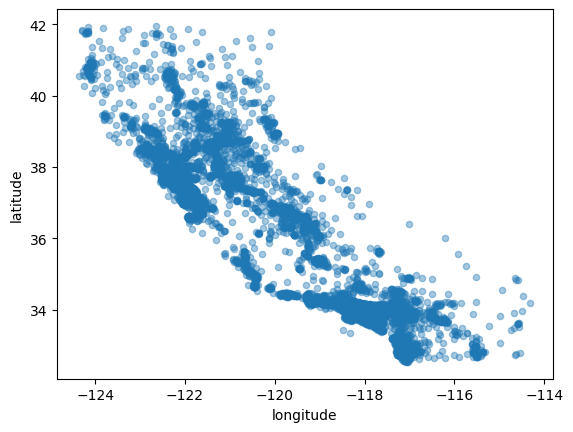

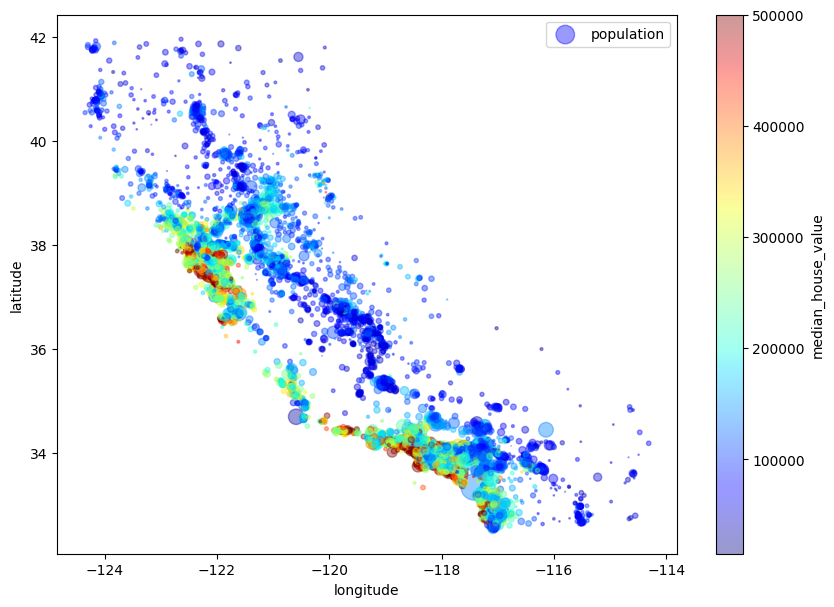

In [168]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,)
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10, 7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)

<Axes: xlabel='longitude', ylabel='latitude'>

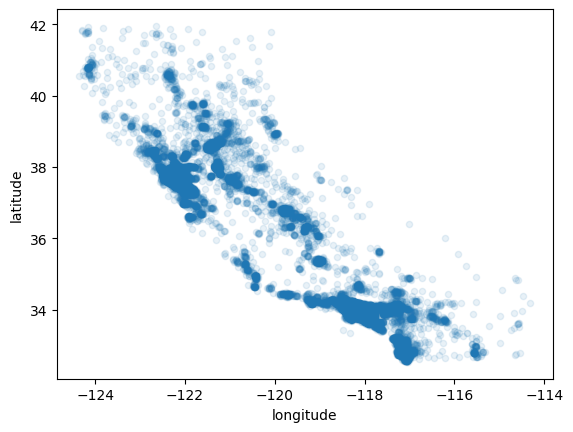

In [169]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

### Buscando correlações entre as variáveis   

In [170]:
colunas_numericas = housing.select_dtypes(include=['int64', 'float64']).columns  # Seleciona apenas colunas numéricas
corr_matrix = housing[colunas_numericas].corr()  # Calcula a matriz de correlação
corr_matrix["median_house_value"].sort_values(ascending=False)  # Ordena a corre

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

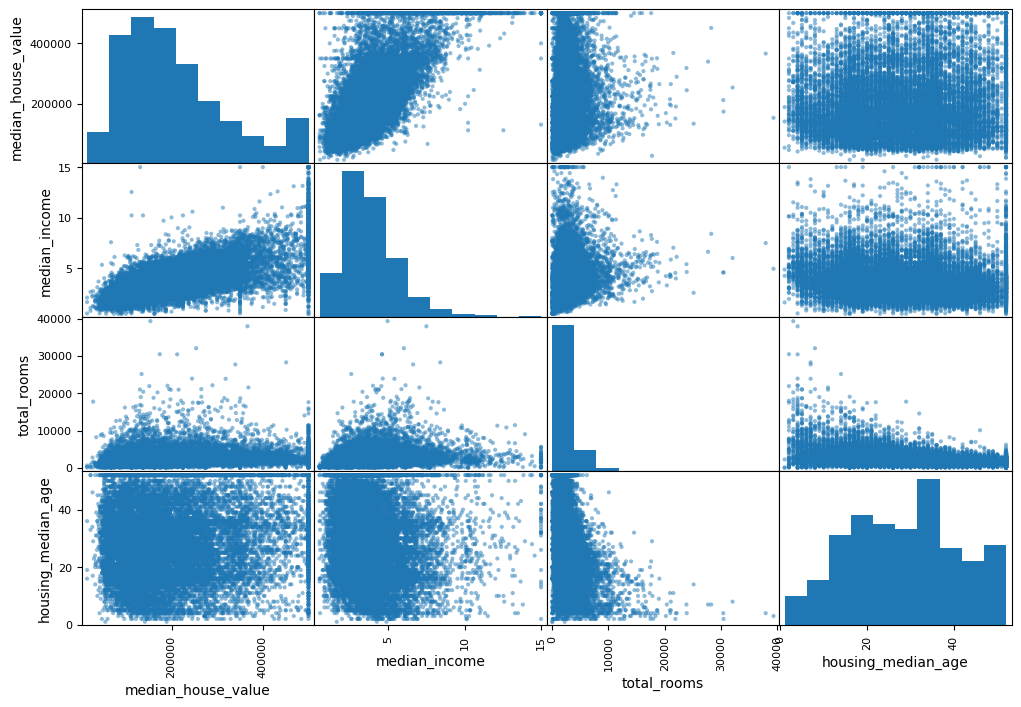

In [171]:
attributes = ["median_house_value", "median_income", "total_rooms", 
              "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))
plt.show()

In [172]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]  # Cria uma nova coluna "rooms_per_household" com a média de quartos por domicílio
housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]  # Cria uma nova coluna "bedrooms_per_room" com a média de quartos por domicílio
housing["population_per_household"] = housing["population"] / housing["households"]

In [173]:
housing_encoded = pd.get_dummies(housing, drop_first=True)
corr_matrix = housing_encoded.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value            1.000000
median_income                 0.687151
ocean_proximity_NEAR BAY      0.158691
rooms_per_household           0.146255
ocean_proximity_NEAR OCEAN    0.137332
total_rooms                   0.135140
housing_median_age            0.114146
households                    0.064590
total_bedrooms                0.047781
ocean_proximity_ISLAND        0.013708
population_per_household     -0.021991
population                   -0.026882
longitude                    -0.047466
latitude                     -0.142673
bedrooms_per_room            -0.259952
ocean_proximity_INLAND       -0.482853
Name: median_house_value, dtype: float64

### Preparação dos dados para Aprendizado de Máquina

In [174]:
housing =  strat_test_set.drop("median_house_value", axis=1)  # Remove a coluna "median_house_value" do conjunto de teste
housing_labels = strat_test_set["median_house_value"].copy()  # Cria uma cópia da coluna "median_house_value" do conjunto de teste para usar como rótulo

In [175]:
imputer =  SimpleImputer(strategy="median")  # Cria um objeto SimpleImputer para substituir valores ausentes pela mediana


In [176]:
housing_num = housing.drop("ocean_proximity", axis=1)  # Remove a coluna categórica "ocean_proximity" para trabalhar apenas com dados numéricos
imputer.fit(housing_num)  # Ajusta o imputer aos dados numéricos do conjunto de treino

SimpleImputer(strategy='median')

In [177]:
imputer = SimpleImputer(strategy="median")
imputer.fit(housing_num)

print(imputer.statistics_)   # aqui já retorna um np.array
print(housing_num.median().values)

[-118.46     34.22     28.     2159.5     442.     1172.5     416.
    3.5132]
[-118.46     34.22     28.     2159.5     442.     1172.5     416.
    3.5132]


In [178]:
x = imputer.transform(housing_num)  # Aplica a transformação para substituir valores ausentes pela mediana

In [179]:
housing_tr = pd.DataFrame(x, columns=housing_num.columns, index=housing.index)  # Cria um novo DataFrame com os dados transformados

In [180]:
housing_cat = housing[["ocean_proximity"]]  # Seleciona a coluna categórica "ocean_proximity"
housing_cat.head()  # Exibe as primeiras linhas da coluna categórica

,ocean_proximity
5241,<1H OCEAN
17352,<1H OCEAN
3505,<1H OCEAN
7777,<1H OCEAN
14155,NEAR OCEAN


In [181]:
ordinal_encoder = OrdinalEncoder()  # Cria um objeto OrdinalEncoder para codificação ordinal
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)  # Aplica a codificação ordinal à coluna categórica
housing_cat_encoded[:10]  # Exibe as primeiras 10 linhas dos dados codificados

array([[0.],
       [0.],
       [0.],
       [0.],
       [4.],
       [0.],
       [3.],
       [4.],
       [0.],
       [4.]])

In [182]:
ordinal_encoder.categories_  # Exibe as categorias codificadas pelo OrdinalEncoder

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [183]:
cat_encoder = OneHotEncoder()  # Cria um objeto OneHotEncoder para codificação one-hot
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)  # Aplica a codificação one-hot à coluna categórica
housing_cat_1hot  # Converte a matriz esparsa resultante

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 4128 stored elements and shape (4128, 5)>

In [184]:
housing_cat_1hot.toarray()  # Converte a matriz esparsa em um array denso para visualização

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], shape=(4128, 5))

In [185]:
cat_encoder.categories_ # Exibe as categorias codificadas pelo OneHotEncoder

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]